# NCP, Fe uptake, lims,Fe timeseries from the CESM-LE

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
#from collections import OrderedDict
import xarray as xr
import numpy as np
#import dask
#from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
#style.use('ggplot')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Get the CESM-LE variables (annual means calculated in cesm-le-annual-means-v2.ipynb)

In [2]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['Fe_avg_150m','SHF_QSW','Jint_100m_DIC','Jint_100m_Fe',
             'sp_Cweight_Fe_lim','sp_Cweight_light_lim',
            'diat_Cweight_Fe_lim','diat_Cweight_light_lim']

ds_list = []
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

Fe_avg_150m
SHF_QSW
Jint_100m_DIC
Jint_100m_Fe
sp_Cweight_Fe_lim
sp_Cweight_light_lim
diat_Cweight_Fe_lim
diat_Cweight_light_lim
CPU times: user 617 ms, sys: 44.9 ms, total: 661 ms
Wall time: 1.15 s


#### get Fe flux up separately because the time dimension needs to be fixed

In [3]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['Fe_FLUX_IN_100m']

ds_list = []
ds2 = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds2 = xr.merge((ds2, dsv))
    ds_list.append(ds2)

Fe_FLUX_IN_100m
CPU times: user 11.3 ms, sys: 3.24 ms, total: 14.5 ms
Wall time: 68.1 ms


In [4]:
ds2['time'] = ds['time']

In [5]:
ds = xr.merge((ds, ds2))

In [6]:
ds.Fe_avg_150m

<xarray.DataArray 'Fe_avg_150m' (time: 181, member_id: 34, nlat: 384, nlon: 320)>
dask.array<open_dataset-f0073a1a39df2e380552ac0a65db6aadFe_avg_150m, shape=(181, 34, 384, 320), dtype=float64, chunksize=(181, 34, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * time       (time) int64 1920 1921 1922 1923 1924 ... 2097 2098 2099 2100
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Fe avg in the top 150m
    units:         mmol/m^3
    grid_loc:      3111
    cell_methods:  time: mean

### calculate NCP and Fe uptake and convert units

In [7]:
nmol_cm2_s_to_nmol_m2_d = 10000. * 86400.
ds['Fe_FLUX_IN_100m'] = ds['Fe_FLUX_IN_100m'] * nmol_cm2_s_to_nmol_m2_d
ds.Fe_FLUX_IN_100m.attrs['units'] = 'nmol/m^2/d'

In [8]:
convert = 0.01 * 86400.
ds['NCP'] = (-1.) * ds.Jint_100m_DIC * convert
ds.NCP.attrs = ds.Jint_100m_DIC.attrs
ds.NCP.attrs['units'] = 'mmol/m^2/d'

In [9]:
convert = 0.01 * 86400. * 1000.  #
ds['Bio_Fe_uptake'] = (-1.) * ds.Jint_100m_Fe * convert
ds.Bio_Fe_uptake.attrs = ds.Jint_100m_Fe.attrs
ds.Bio_Fe_uptake.attrs['units'] = 'µmol/m^2/d'

In [10]:
variables = ['Fe_avg_150m','SHF_QSW','NCP','Fe_FLUX_IN_100m',
             'Bio_Fe_uptake','sp_Cweight_Fe_lim','sp_Cweight_light_lim',
             'Fe_FLUX_IN_100m','diat_Cweight_Fe_lim','diat_Cweight_light_lim']

In [11]:
convert = 1000. #Convert. Fe from mmol/m3 to µmol/m3
ds['Fe_avg_150m'] = ds.Fe_avg_150m * convert
ds.Fe_avg_150m.attrs['units'] = 'µmol/m^3'

### get pop grid

In [12]:
grid = pop_tools.get_grid('POP_gx1v6')

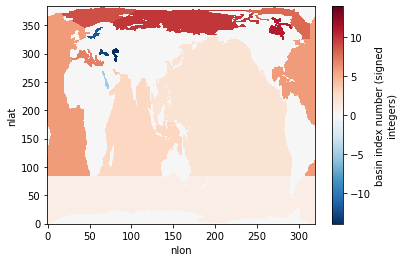

In [13]:
grid.REGION_MASK.plot()

In [14]:
lons = grid.TLONG
lats = grid.TLAT
years = ds.time.values
years

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 20

### mask out nans in ds

In [15]:
ds = ds.where(grid.REGION_MASK>0)

### get masks for making averages

In [16]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1990s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

### Make timeseries

In [17]:
variables

['Fe_avg_150m',
 'SHF_QSW',
 'NCP',
 'Fe_FLUX_IN_100m',
 'Bio_Fe_uptake',
 'sp_Cweight_Fe_lim',
 'sp_Cweight_light_lim',
 'Fe_FLUX_IN_100m',
 'diat_Cweight_Fe_lim',
 'diat_Cweight_light_lim']

### ACC

In [18]:
%%time

ts_ACC = xr.Dataset({v: ds[v] for v in ['time','member_id']})

for v in variables:
    
    masked = ds[v].where(ds_masks.ACC_mask==1.)
    ts_ACC[v] = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()


CPU times: user 2min 27s, sys: 1min 50s, total: 4min 17s
Wall time: 3min 40s


### SIZ

In [19]:
%%time

ts_SIZ = xr.Dataset({v: ds[v] for v in ['time','member_id']})

for v in variables:
    print(v)
    masked = ds[v].where(ds_masks.SIZ_mask==1.)
    ts_SIZ[v] = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()

Fe_avg_150m
SHF_QSW
NCP
Fe_FLUX_IN_100m
Bio_Fe_uptake
sp_Cweight_Fe_lim
sp_Cweight_light_lim
Fe_FLUX_IN_100m
diat_Cweight_Fe_lim
diat_Cweight_light_lim
CPU times: user 2min 28s, sys: 1min 50s, total: 4min 19s
Wall time: 3min 20s


In [20]:
ts_ACC_ens_mean = ts_ACC.mean(dim='member_id')
ts_SIZ_ens_mean = ts_SIZ.mean(dim='member_id')

### SIZ line plots

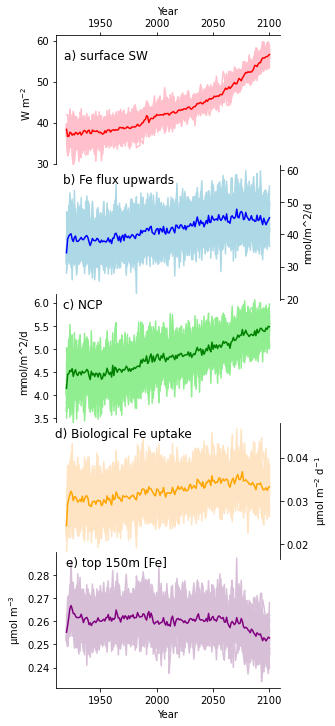

In [21]:
fig, ax = plt.subplots(nrows=5,ncols=1,figsize=(4,12))
ax[0].set_title('a) surface SW', x=0.22,y=0.78)
ax[0].set_ylabel('W m$^{-2}$')
ax[0].set_xlabel('Year')
#ax[0].set_ylim(1.4,2.05)
for mem in np.arange(0,34,1):

    ax[0].plot(years, 
         ts_SIZ['SHF_QSW'].isel(member_id=mem), 
         color='pink')

ax[0].plot(years, ts_SIZ_ens_mean['SHF_QSW'], 
         color='red')
# Hide the right and top spines
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].xaxis.set_label_position("top")
ax[0].xaxis.tick_top()
############

ax[1].set_title('b) Fe flux upwards',x=0.28, y=0.82)
ax[1].set_ylabel('nmol/m^2/d')
#ax[1].set_ylim(75,85)
for mem in np.arange(0,34,1):

    ax[1].plot(years, 
         ts_SIZ['Fe_FLUX_IN_100m'].isel(member_id=mem), 
         color='lightblue')

ax[1].plot(years, ts_SIZ_ens_mean['Fe_FLUX_IN_100m'], 
         color='blue');
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right();
ax[1].xaxis.set_visible(False)
############

ax[2].set_title('c) NCP',x=0.12, y=0.85)
ax[2].set_ylabel('mmol/m^2/d')

ax[2].xaxis.set_visible(False)
#ax[2].set_ylim(31,43)
for mem in np.arange(0,34,1):

    ax[2].plot(years, 
         ts_SIZ['NCP'].isel(member_id=mem), 
         color='lightgreen')

ax[2].plot(years, ts_SIZ_ens_mean['NCP'], 
         color='green')
ax[2].spines['top'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].spines['right'].set_visible(False)
############

ax[3].set_title('d) Biological Fe uptake',x=0.3, y=0.85)
ax[3].set_ylabel('µmol m$^{-2}$ d$^{-1}$')

ax[3].xaxis.set_visible(False)
ax[3].yaxis.tick_right();

ax[3].yaxis.set_label_position("right")
#ax[3].set_ylim(31,43)
for mem in np.arange(0,34,1):

    ax[3].plot(years, 
         ts_SIZ['Bio_Fe_uptake'].isel(member_id=mem), 
         color='bisque')

ax[3].plot(years, ts_SIZ_ens_mean['Bio_Fe_uptake'], 
         color='orange')
ax[3].spines['top'].set_visible(False)
ax[3].spines['bottom'].set_visible(False)
ax[3].spines['left'].set_visible(False)

############

ax[4].set_title('e) top 150m [Fe]',x=0.27, y=0.85)
ax[4].set_ylabel('µmol m$^{-3}$')
#ax[4].yaxis.set_label_position("right")
ax[4].set_xlabel('Year')
#ax[4].set_ylim(31,43)
for mem in np.arange(0,34,1):

    ax[4].plot(years, 
         ts_SIZ['Fe_avg_150m'].isel(member_id=mem), 
         color='thistle')

ax[4].plot(years, ts_SIZ_ens_mean['Fe_avg_150m'], 
         color='purple')
#ax[4].yaxis.tick_right();
ax[4].spines['top'].set_visible(False)
ax[4].spines['right'].set_visible(False)
#ax[3].spines['bottom'].set_visible(False)



fig.subplots_adjust(hspace=-0.05)





#fig.savefig('/glade/work/kristenk/figs/zoo_ts_CESM-le.png', bbox_inches='tight', dpi=300, format='png');


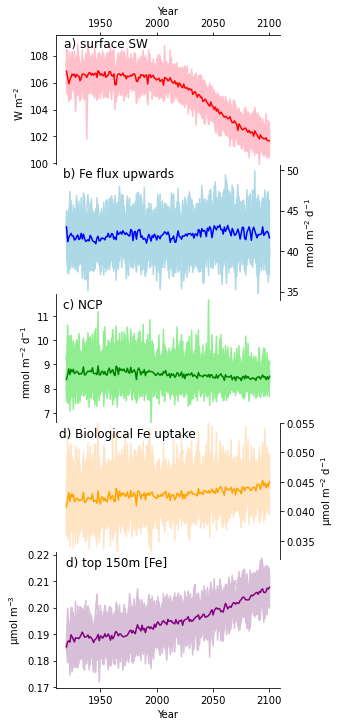

In [22]:
fig, ax = plt.subplots(nrows=5,ncols=1,figsize=(4,12))
ax[0].set_title('a) surface SW', x=0.22,y=0.87)
ax[0].set_ylabel('W m$^{-2}$')
ax[0].set_xlabel('Year')
#ax[0].set_ylim(1.4,2.05)
for mem in np.arange(0,34,1):

    ax[0].plot(years, 
         ts_ACC['SHF_QSW'].isel(member_id=mem), 
         color='pink')

ax[0].plot(years, ts_ACC_ens_mean['SHF_QSW'], 
         color='red')
# Hide the right and top spines
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].xaxis.set_label_position("top")
ax[0].xaxis.tick_top()
############

ax[1].set_title('b) Fe flux upwards',x=0.28, y=0.86)
ax[1].set_ylabel('nmol m$^{-2}$ d$^{-1}$')
#ax[1].set_ylim(75,85)
for mem in np.arange(0,34,1):

    ax[1].plot(years, 
         ts_ACC['Fe_FLUX_IN_100m'].isel(member_id=mem), 
         color='lightblue')

ax[1].plot(years, ts_ACC_ens_mean['Fe_FLUX_IN_100m'], 
         color='blue');
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right();
ax[1].xaxis.set_visible(False)
############

ax[2].set_title('c) NCP',x=0.12, y=0.85)
ax[2].set_ylabel('mmol m$^{-2}$ d$^{-1}$')

ax[2].xaxis.set_visible(False)
#ax[2].set_ylim(31,43)
for mem in np.arange(0,34,1):

    ax[2].plot(years, 
         ts_ACC['NCP'].isel(member_id=mem), 
         color='lightgreen')

ax[2].plot(years, ts_ACC_ens_mean['NCP'], 
         color='green')
ax[2].spines['top'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].spines['right'].set_visible(False)
############

ax[3].set_title('d) Biological Fe uptake',x=0.32, y=0.85)
ax[3].set_ylabel('µmol m$^{-2}$ d$^{-1}$')

ax[3].xaxis.set_visible(False)
ax[3].yaxis.tick_right();

ax[3].yaxis.set_label_position("right")
ax[3].set_ylim(0.032,0.055)
for mem in np.arange(0,34,1):

    ax[3].plot(years, 
         ts_ACC['Bio_Fe_uptake'].isel(member_id=mem), 
         color='bisque')

ax[3].plot(years, ts_ACC_ens_mean['Bio_Fe_uptake'], 
         color='orange')
ax[3].spines['top'].set_visible(False)
ax[3].spines['bottom'].set_visible(False)
ax[3].spines['left'].set_visible(False)

############

ax[4].set_title('d) top 150m [Fe]',x=0.27, y=0.85)
ax[4].set_ylabel('µmol m$^{-3}$')
#ax[4].yaxis.set_label_position("right")
ax[4].set_xlabel('Year')
#ax[4].set_ylim(31,43)
for mem in np.arange(0,34,1):

    ax[4].plot(years, 
         ts_ACC['Fe_avg_150m'].isel(member_id=mem), 
         color='thistle')

ax[4].plot(years, ts_ACC_ens_mean['Fe_avg_150m'], 
         color='purple')
#ax[4].yaxis.tick_right();
ax[4].spines['top'].set_visible(False)
ax[4].spines['right'].set_visible(False)
#ax[3].spines['bottom'].set_visible(False)



fig.subplots_adjust(hspace=-0.05)






#fig.savefig('/glade/work/kristenk/figs/zoo_ts_CESM-le.png', bbox_inches='tight', dpi=300, format='png');


In [27]:
ACC_Fe_1920s = ts_ACC_ens_mean['Fe_avg_150m'].isel(time=slice(0,10)).mean(dim='time')
ACC_Fe_1920s.values

array(0.18776172)

In [28]:
ACC_Fe_2090s = ts_ACC_ens_mean['Fe_avg_150m'].isel(time=slice(-11,-1)).mean(dim='time')
ACC_Fe_2090s.values

array(0.20625789)

### now put the plots together

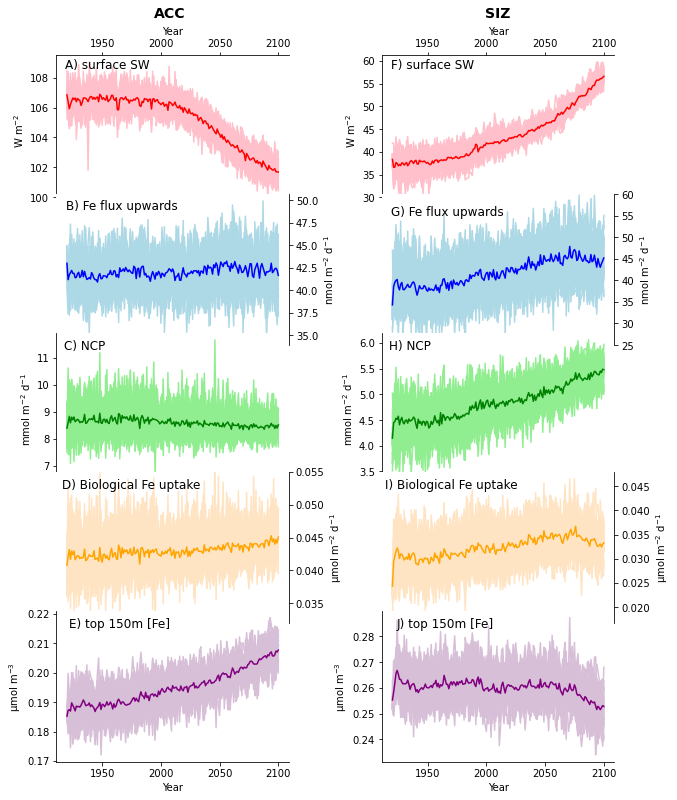

In [24]:
fig, ax = plt.subplots(nrows=5,ncols=2,figsize=(10,13))
ax[0,0].set_title('A) surface SW', x=0.22,y=0.87)
ax[0,0].set_ylabel('W m$^{-2}$')
ax[0,0].set_xlabel('Year')
#ax[0].set_ylim(1.4,2.05)
for mem in np.arange(0,34,1):

    ax[0,0].plot(years, 
         ts_ACC['SHF_QSW'].isel(member_id=mem), 
         color='pink')

ax[0,0].plot(years, ts_ACC_ens_mean['SHF_QSW'], 
         color='red')
# Hide the right and top spines
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['bottom'].set_visible(False)
ax[0,0].xaxis.set_label_position("top")
ax[0,0].xaxis.tick_top()
############

# ############

ax[1,0].set_title('B) Fe flux upwards',x=0.28, y=0.86)
ax[1,0].set_ylabel('nmol m$^{-2}$ d$^{-1}$')
#ax[2].set_ylim(75,85)
for mem in np.arange(0,34,1):

    ax[1,0].plot(years, 
         ts_ACC['Fe_FLUX_IN_100m'].isel(member_id=mem), 
         color='lightblue')

ax[1,0].plot(years, ts_ACC_ens_mean['Fe_FLUX_IN_100m'], 
         color='blue');
ax[1,0].spines['left'].set_visible(False)
ax[1,0].spines['bottom'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[1,0].yaxis.set_label_position("right")
ax[1,0].yaxis.tick_right();
ax[1,0].xaxis.set_visible(False)
# ############

ax[2,0].set_title('C) NCP',x=0.12, y=0.85)
ax[2,0].set_ylabel('mmol m$^{-2}$ d$^{-1}$')

ax[2,0].xaxis.set_visible(False)
#ax[2,0].set_ylim(31,43)
for mem in np.arange(0,34,1):

    ax[2,0].plot(years, 
         ts_ACC['NCP'].isel(member_id=mem), 
         color='lightgreen')

ax[2,0].plot(years, ts_ACC_ens_mean['NCP'], 
         color='green')
ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['bottom'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
############


ax[3,0].set_title('D) Biological Fe uptake',x=0.32, y=0.85)
ax[3,0].set_ylabel('µmol m$^{-2}$ d$^{-1}$')

ax[3,0].xaxis.set_visible(False)
ax[3,0].yaxis.tick_right();

ax[3,0].yaxis.set_label_position("right")
ax[3,0].set_ylim(0.032,0.055)
for mem in np.arange(0,34,1):

    ax[3,0].plot(years, 
         ts_ACC['Bio_Fe_uptake'].isel(member_id=mem), 
         color='bisque')

ax[3,0].plot(years, ts_ACC_ens_mean['Bio_Fe_uptake'], 
         color='orange')
ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['bottom'].set_visible(False)
ax[3,0].spines['left'].set_visible(False)

############

ax[4,0].set_title('E) top 150m [Fe]',x=0.27, y=0.85)
ax[4,0].set_ylabel('µmol m$^{-3}$')
#ax[4,0].yaxis.set_label_position("right")
ax[4,0].set_xlabel('Year')
#ax[4,0].set_ylim(31,43)
for mem in np.arange(0,34,1):

    ax[4,0].plot(years, 
         ts_ACC['Fe_avg_150m'].isel(member_id=mem), 
         color='thistle')

ax[4,0].plot(years, ts_ACC_ens_mean['Fe_avg_150m'], 
         color='purple')
#ax[4,0].yaxis.tick_right();
ax[4,0].spines['top'].set_visible(False)
ax[4,0].spines['right'].set_visible(False)
#ax[4,0].spines['bottom'].set_visible(False)


################################################### SIZ
ax[0,1].set_title('F) surface SW', x=0.22,y=0.87)
ax[0,1].set_ylabel('W m$^{-2}$')
ax[0,1].set_xlabel('Year')
#ax[0,1].set_ylim(1.4,2.05)
for mem in np.arange(0,34,1):

    ax[0,1].plot(years, 
         ts_SIZ['SHF_QSW'].isel(member_id=mem), 
         color='pink')

ax[0,1].plot(years, ts_SIZ_ens_mean['SHF_QSW'], 
         color='red')
# Hide the right and top spines
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['bottom'].set_visible(False)
ax[0,1].xaxis.set_label_position("top")
ax[0,1].xaxis.tick_top()
############

ax[1,1].set_title('G) Fe flux upwards',x=0.28, y=0.82)
ax[1,1].set_ylabel('nmol m$^{-2}$ d$^{-1}$')
ax[1,1].set_ylim(25,60)
for mem in np.arange(0,34,1):

    ax[1,1].plot(years, 
         ts_SIZ['Fe_FLUX_IN_100m'].isel(member_id=mem), 
         color='lightblue')

ax[1,1].plot(years, ts_SIZ_ens_mean['Fe_FLUX_IN_100m'], 
         color='blue');
ax[1,1].spines['left'].set_visible(False)
ax[1,1].spines['bottom'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)
ax[1,1].yaxis.set_label_position("right")
ax[1,1].yaxis.tick_right();
ax[1,1].xaxis.set_visible(False)
############

ax[2,1].set_title('H) NCP',x=0.12, y=0.85)
ax[2,1].set_ylabel('mmol m$^{-2}$ d$^{-1}$')

ax[2,1].xaxis.set_visible(False)
#ax[2,1].set_ylim(31,43)
for mem in np.arange(0,34,1):

    ax[2,1].plot(years, 
         ts_SIZ['NCP'].isel(member_id=mem), 
         color='lightgreen')

ax[2,1].plot(years, ts_SIZ_ens_mean['NCP'], 
         color='green')
ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['bottom'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
############

ax[3,1].set_title('I) Biological Fe uptake',x=0.3, y=0.85)
ax[3,1].set_ylabel('µmol m$^{-2}$ d$^{-1}$')

ax[3,1].xaxis.set_visible(False)
ax[3,1].yaxis.tick_right();

ax[3,1].yaxis.set_label_position("right")
#ax[3,1].set_ylim(31,43)
for mem in np.arange(0,34,1):

    ax[3,1].plot(years, 
         ts_SIZ['Bio_Fe_uptake'].isel(member_id=mem), 
         color='bisque')

ax[3,1].plot(years, ts_SIZ_ens_mean['Bio_Fe_uptake'], 
         color='orange')
ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['bottom'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)

############

ax[4,1].set_title('J) top 150m [Fe]',x=0.27, y=0.85)
ax[4,1].set_ylabel('µmol m$^{-3}$')
#ax[4,1].yaxis.set_label_position("right")
ax[4,1].set_xlabel('Year')
#ax[4,1].set_ylim(31,43)
for mem in np.arange(0,34,1):

    ax[4,1].plot(years, 
         ts_SIZ['Fe_avg_150m'].isel(member_id=mem), 
         color='thistle')

ax[4,1].plot(years, ts_SIZ_ens_mean['Fe_avg_150m'], 
         color='purple')
#ax[4,1].yaxis.tick_right();
ax[4,1].spines['top'].set_visible(False)
ax[4,1].spines['right'].set_visible(False)
#ax[4,1].spines['bottom'].set_visible(False)


fig.subplots_adjust(hspace=-0.08,wspace=0.4)

plt.figtext(0.26, 0.92, 'ACC', fontsize=14,fontweight='bold')
plt.figtext(0.72, 0.92, 'SIZ', fontsize=14,fontweight='bold')




fig.savefig('/glade/work/kristenk/figs/NCP_Fe_drivers_lineplots.png', bbox_inches='tight', dpi=300, format='png');
